# Homework 12 Computational Problems

## Linear Regression on Boston Housing data

Let's apply what we've learned about linear regression to an actual dataset, the Boston housing dataset (see https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html for a description), which is loaded below. 

In [15]:
# Run this cell without changing anything.
from sklearn.datasets import load_boston
import numpy as np

boston_dataset = load_boston()

X = boston_dataset.data
y = boston_dataset.target
X = np.delete(X, [11], axis=1)
n,p = X.shape

/Users/rythei/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California hou

As we see, this dataset has $p=12$ predictor variables, and $n=506$ samples.

### Part 1 Adding a column of ones

In the cell below, append a column of 1's to the matrix $\mathbf{X}$.

In [16]:
X = np.append(X, np.ones(X.shape[0]).reshape(-1,1), 1)
X.shape

(506, 13)

### Part 2 Computing the least squares coefficients

Recall the to solution to the least-squares problem is given by:

$$
\hat{\boldsymbol{b}} = (\boldsymbol{X^\top X})^{-1}\boldsymbol{X^\top y} = \text{argmin}_{\boldsymbol{b}} \|\boldsymbol{Xb} - \boldsymbol{y}\|_2^2 
$$


Compute the least squares coefficients for the data housing data.

In [17]:
b_hat = np.dot(np.linalg.inv(X.T@X)@X.T, y)

### Part 3 Plotting residuals

Next, we look at one important way to visualize the the quality of the fit from least squares using the _residuals_. The residuals are defined as the difference between the predicted $y$ values and the true $y$ values:

$$
\mathbf{e} = \mathbf{y} - \hat{\mathbf{y}} = \mathbf{y} - \mathbf{X}\hat{\mathbf{b}}
$$

In the cell below, fill in the function ```compute_residuals``` to compute this vector of residuals for a given data matrix $\mathbf{X}$, response vector $\mathbf{y}$ and coefficient vector $\hat{\mathbf{b}}$.

In [18]:
def compute_residuals(X, y, b):
    '''
    Arguments:
        X: n x (p+1) array of predictor variables
        y: length n array of respones
        b: length (p+1) array of regression coefficients
    Returns:
        array e containing residuals y - y_hat
    '''
    return y - np.dot(X, b)

Next, let's use this function to plot the residuals:

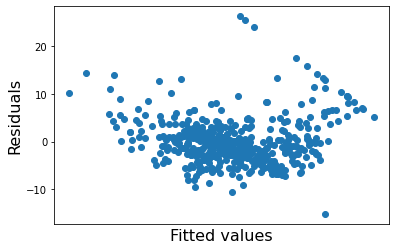

In [19]:
import matplotlib.pyplot as plt

def plot_residuals(X, y, b):
    residuals = compute_residuals(X, y, b)
    fitted_values = np.dot(X,b)
    plt.scatter(fitted_values, residuals)
    plt.xticks(())
    plt.xlabel('Fitted values', fontsize=16)
    plt.ylabel('Residuals', fontsize=16)
    plt.show()
    
plot_residuals(X, y, b_hat)

To interpret the residual plot, let's first recall our regression model:

$$
y = b_0 + b_1 X_1 + b_2 X_2 + \cdots +  b_p X_p +\varepsilon
$$

where we assume $\varepsilon \sim N(0,\sigma^2)$ is a noise variable. If we plug in the fitted coefficients $\hat{b}_i$ and subtract the fitted values from each side, we get that

$$
y - (\hat{b}_0 + \hat{b}_1 X_1 + \hat{b}_2 X_2 + \cdots +  \hat{b}_p X_p) = \varepsilon
$$

Thus, if our model is correct, we expect the residuals to be roughly normaly with mean zero. As we see from the plot above, the residuals do seem to be centered around zero. However, it's not clear from this plot alone that they actually follow a normal distribution. Let's look at the histogram of the residuals to get a slightly better picture of their distribution.


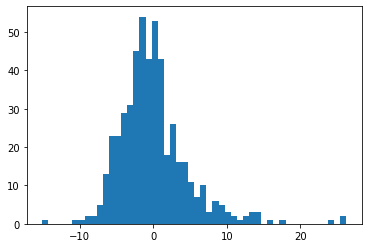

In [20]:
residuals = compute_residuals(X, y, b_hat)
plt.hist(residuals, bins=50)
plt.show()

From this plot, we see that the residuals do roughly fit a bell curve shape of a normal distribution, but it's not quite clear how well. In the next section, we investigate a more refined way to assess how well the residuals follow a normal distribution.

### Part 4 QQ plots

A QQ (quantile-quantile) plot is a popular way to assess how well two distributions match. If you're familiar with some probability, you can read more about QQ plots on the [Wikipedia page](https://en.wikipedia.org/wiki/Q–Q_plot). For now, it will suffice to know that it's a convenient way to visualize how well two distributions match.

In our case, we want to see how well the residuals follow a $N(0,\sigma^2)$ distribution. To do this, we first need to know the variance $\sigma^2$. We can estimate this from our residuals using the following formula:

$$
\hat{\sigma}^2 = \frac{1}{n-2}(\mathbf{y}-\hat{\mathbf{y}})^\top(\mathbf{y} - \hat{\mathbf{y}}) = \frac{1}{n-2}(\mathbf{y}-\mathbf{X}\hat{\mathbf{b}})^\top(\mathbf{y} - \mathbf{X}\hat{\mathbf{b}})
$$

Fill in the function ```estimate_residual_variance``` below to compute $\hat{\sigma}^2$ below (hint: you can use your ```compute_residuals``` function you defined above).

In [21]:
def estimate_residual_variance(X, y, b):
    '''
    Arguments:
        X: n x (p+1) array of predictor variables
        y: length n vector of respones
        b: length (p+1) vector of regression coefficients
        
    Returns:
        float sigma2, which is an estimate of the variance of epsilon in the regression model
    '''
    e = compute_residuals(X, y, b)
    n = X.shape[0]
    return (1/(n-2))*np.dot(e, e)

The QQ plot compares two distributions by measuring how much their _quantiles_ align. We do this by plotting the quantiles of the residual distribution versus the quantiles of a normal distribution. Ideally, these would match exactly, and we would have that the quantiles lie on exactly on the line $y=x$. The following function uses your ```estimate_residual_variance``` and ```compute_residuals``` functions to generate a QQ plot.

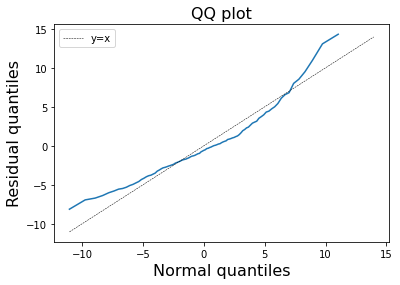

In [22]:
from scipy.stats import norm

def residual_quantile(q, residuals):
    return np.quantile(residuals, q)

def QQ_plot(X, y, b):
    residuals = compute_residuals(X, y, b)
    sigma2 = estimate_residual_variance(X, y, b)
    q_range = np.arange(0.01,1,.01)
    qq_data = []
    for q in q_range:
        res_q = residual_quantile(q, residuals)
        norm_q = norm.ppf(q, scale=np.sqrt(sigma2))
        qq_data.append([norm_q, res_q])
    
    qq_data = np.array(qq_data)
    x_lb = np.min(qq_data)
    x_ub = np.max(qq_data)
    xran = np.arange(x_lb,x_ub)
    plt.plot(qq_data[:,0], qq_data[:,1])
    plt.plot(xran, xran, color='black', linestyle='--', linewidth=.5, label='y=x')
    plt.legend()
    plt.ylabel('Residual quantiles', fontsize=16)
    plt.xlabel('Normal quantiles', fontsize=16)
    plt.title('QQ plot', fontsize=16)
    plt.show()

QQ_plot(X, y, b_hat)
        

As we can see, the QQ plot shows that the quantiles of the two distributions don't quite align (i.e., the quantiles do not lie near the line $y=x$). As we will see in the next problem, we can sometimes obtain a better fit by transforming the data.

### Part 5 Regression with transformed data

One method that is sometimes used to obtain a better fit in linear regression is to transform either the predictor variables or the response variable. Use the functions you've written in parts 1-4 to fit another regression model, except using $\log(y)$ as the response rather than $y$. Plot the QQ function of the new regression model. How does it compare the one we obtain in Part 4?

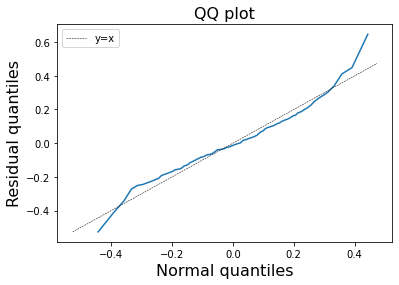

array([3.17805383, 3.07269331, 3.54673969, 3.5085559 , 3.58905912,
       3.35689712, 3.13113691, 3.29953373, 2.80336038, 2.93916192,
       2.7080502 , 2.93916192, 3.07731226, 3.0155349 , 2.90142159,
       2.99071973, 3.13983262, 2.86220088, 3.0056826 , 2.90142159,
       2.61006979, 2.97552957, 2.72129543, 2.67414865, 2.74727091,
       2.63188884, 2.8094027 , 2.69462718, 2.91235066, 3.04452244,
       2.54160199, 2.67414865, 2.58021683, 2.57261223, 2.60268969,
       2.93916192, 2.99573227, 3.04452244, 3.20680324, 3.42751469,
       3.55248683, 3.28091122, 3.2308044 , 3.20680324, 3.05400118,
       2.9601051 , 2.99573227, 2.8094027 , 2.66722821, 2.96527307,
       2.98061864, 3.02042489, 3.21887582, 3.15273602, 2.93916192,
       3.56671182, 3.20680324, 3.45315712, 3.14845336, 2.97552957,
       2.92852352, 2.77258872, 3.10009229, 3.21887582, 3.49650756,
       3.15700042, 2.96527307, 3.09104245, 2.85647021, 3.03974916,
       3.18635263, 3.07731226, 3.12676054, 3.15273602, 3.18221

In [23]:
ylog = np.log(y)
b_hat_log = np.dot(np.linalg.inv(X.T@X)@X.T, ylog)
QQ_plot(X, ylog, b_hat_log)
ylog

### Part 6 Confidence intervals for the regression coefficients

Given a regression model 

$$
y = \boldsymbol{b}^\top \boldsymbol{x} + \varepsilon
$$

with $\text{Var}(\varepsilon) = \sigma^2$ and the least squares estimate $\hat{\boldsymbol{\beta}}$ for the coefficients, we have a closed formula for the covariance matrix of the coefficients $\hat{\boldsymbol{\beta}}$:

$$
\text{Cov}(\hat{\boldsymbol{b}}) = \sigma^2 (\boldsymbol{X^\top X})^{-1} \approx \hat{\sigma}^2 (\boldsymbol{X^\top X})^{-1} = \hat{\boldsymbol{C}}
$$

where $\hat{\sigma}^2$ is the estimator defined in Part 4. This formula is extremely convenient because it allows us to form approximate 95% confidence intervals for the coefficients $\hat{\boldsymbol{b}}$ as follows:  

$$
\text{CI}_{0.95}(\hat{b}_j) = [\hat{b}_j - 2\sqrt{\boldsymbol{C}_{jj}}, \hat{b}_j + 2\sqrt{\boldsymbol{C}_{jj}}]
$$

Construct these confidence intervals for the each of the coefficients found in Part 5, and report which features' confidence intervals _do not_ contain the value 0 (meaning that with probability >= 0.95, these coefficients are greater different from zero).